In [1]:
%run imports.ipynb

In [2]:
import dadi
import sys
import os
import numpy
import dadi
from datetime import datetime

In [8]:
proj = (fs_fw.sample_sizes[0], fs_fw.sample_sizes[1])
proj

(130, 182)

In [13]:
pop_ids=["GM", "GW"]

In [9]:
fs_fw = dadi.Spectrum(np.load("dadi/fs_2_pops/GM_GW.npy"), pop_ids = ['GM', 'GW'])
fs_fw

Spectrum([[-- 142068.0 37092.0 ... 0.0 0.0 0.0]
 [39777.0 17181.0 9725.0 ... 0.0 0.0 0.0]
 [14933.0 8036.0 5498.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 2.0 1.0]
 [0.0 0.0 0.0 ... 0.0 2.0 3.0]
 [0.0 0.0 0.0 ... 3.0 8.0 --]], folded=False, pop_ids=['GM', 'GW'])

In [11]:
print("\n\n============================================================================")
print("\nData for site frequency spectrum:\n")
print("Projection: {}".format(proj))
print("Sample sizes: {}".format(fs_fw.sample_sizes))
print("Sum of SFS: {}".format(np.around(fs_fw.S(), 2)))
print("\n============================================================================\n")




Data for site frequency spectrum:

Projection: (130, 182)
Sample sizes: [130 182]
Sum of SFS: 446514.0




In [123]:
def parse_params(param_number, in_params=None, in_upper=None, in_lower=None):
    #--------------------------------------------------------------------------------------
    # function to correctly deal with parameters and bounds, if none were provided, generate them automatically
    
    # Arguments
    # param_number: number of parameters in the model selected (can count in params line for the model)
    # in_params: a list of parameter values 
    # in_upper: a list of upper bound values
    # in_lower: a list of lower bound values
    #--------------------------------------------------------------------------------------
    param_number = int(param_number)
    
    #param set
    if in_params is None:
        params = [1] * param_number
    elif len(in_params) != param_number:
        raise ValueError("Set of input parameters does not contain the correct number of values: {}".format(param_number))
    else:
        params = in_params
        
    #upper bound    
    if in_upper is None:
        upper_bound = [30] * param_number
    elif len(in_upper) != param_number:
        raise ValueError("Upper bound set for parameters does not contain the correct number of values: {}".format(param_number))
    else:
        upper_bound = in_upper
        
    #lower bounds
    if in_lower is None:
        lower_bound = [0.01] * param_number
    elif len(in_lower) != param_number:
        raise ValueError("Lower bound set for parameters does not contain the correct number of values: {}".format(param_number))
    else:
        lower_bound = in_lower
        
    return params, upper_bound, lower_bound

def parse_opt_settings(rounds, reps=None, maxiters=None, folds=None):
    #--------------------------------------------------------------------------------------
    # function to correctly deal with replicate numbers, maxiter and fold args
    
    # Arguments
    # rounds: number of optimization rounds to perform
    # reps: a list of integers controlling the number of replicates in each of three optimization rounds
    # maxiters: a list of integers controlling the maxiter argument in each of three optimization rounds
    # folds: a list of integers controlling the fold argument when perturbing input parameter values
    #--------------------------------------------------------------------------------------
    rounds = int(rounds)
    
    #rep set
    #create scheme where final replicates will be 20, and all previous 10
    if reps is None:
        if rounds >= 2:
            reps_list = [10] * (rounds-1)
            reps_list.insert(len(reps_list),20)
        else:
            reps_list = [10] * rounds
    elif len(reps) != rounds:
        raise ValueError("List length of replicate values does match the number of rounds: {}".format(rounds))
    else:
        reps_list = reps
        
    #maxiters   
    if maxiters is None:
        maxiters_list = [5] * rounds
    elif len(maxiters) != rounds:
        raise ValueError("List length of maxiter values does match the number of rounds: {}".format(rounds))
    else:
        maxiters_list = maxiters
        
    #folds
    #create scheme so if rounds is greater than three, will always end with two fold and then one fold
    if folds is None:
        if rounds >= 3:
            folds_list = [3] * (rounds-2)
            folds_list.insert(len(folds_list),2)
            folds_list.insert(len(folds_list),1)
        elif rounds == 2:
            folds_list = [2] * (rounds-1)
            folds_list.insert(len(folds_list),1)
        else:
            folds_list = [2] * rounds
    elif len(folds) != rounds:
        raise ValueError("List length of fold values does match the number of rounds: {}".format(rounds))
    else:
        folds_list = folds
        
    return reps_list, maxiters_list, folds_list

def collect_results(fs, sim_model, params_opt, roundrep, fs_folded):
    #--------------------------------------------------------------------------------------
    # gather up a bunch of results, return a list = [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values] 
    
    # Arguments
    # fs: spectrum object name
    # sim_model: model fit with optimized parameters
    # params_opt: list of the optimized parameters
    # fs_folded: a Boolean (True, False) for whether empirical spectrum is folded or not
    #--------------------------------------------------------------------------------------

    #calculate likelihood
    ll = dadi.Inference.ll_multinom(sim_model, fs)
    ll = numpy.around(ll, 2)
    print("\t\t\tLikelihood = {:,}".format(ll))

    #calculate AIC 
    aic = ( -2*( float(ll))) + (2*len(params_opt))
    print("\t\t\tAIC = {:,}".format(aic))

    #calculate theta
    theta = dadi.Inference.optimal_sfs_scaling(sim_model, fs)
    theta = numpy.around(theta, 2)
    print("\t\t\tTheta = {:,}".format(theta))

    #get Chi^2
    scaled_sim_model = sim_model*theta
    if fs_folded is True:
        #calculate Chi^2 statistic for folded
        folded_sim_model = scaled_sim_model.fold()
        chi2 = numpy.sum((folded_sim_model - fs)**2/folded_sim_model)
        chi2 = numpy.around(chi2, 2)
    elif fs_folded is False:
        #calculate Chi^2 statistic for unfolded
        chi2 = numpy.sum((scaled_sim_model - fs)**2/scaled_sim_model)
        chi2 = numpy.around(chi2, 2)
    print("\t\t\tChi-Squared = {:,}".format(chi2))        

    #store key results in temporary sublist, append to larger results list
    temp_results = [roundrep, ll, aic, chi2, theta, params_opt]

    return temp_results

def write_log(outfile, model_name, rep_results, roundrep):
    #--------------------------------------------------------------------------------------
    #reproduce replicate log to bigger log file, because constantly re-written
    
    # Arguments =
    # outfile: prefix for output naming
    # model_name: a label to slap on the output files; ex. "no_mig"
    # rep_results: the list returned by collect_results function: [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values]
    # roundrep: name of replicate (ex, "Round_1_Replicate_10")
    #--------------------------------------------------------------------------------------
    fh_log = open("{0}.{1}.log.txt".format(outfile, model_name), 'a')
    fh_log.write("\n{}\n".format(roundrep))
    templogname = "{}.log.txt".format(model_name)
    try:
        fh_templog = open(templogname, 'r')
        for line in fh_templog:
            fh_log.write(line)
        fh_templog.close()
    except IOError:
        print("Nothing written to log file this replicate...")
    fh_log.write("likelihood = {}\n".format(rep_results[1]))
    fh_log.write("theta = {}\n".format(rep_results[4]))
    fh_log.write("Optimized parameters = {}\n".format(rep_results[5]))
    fh_log.close()

def Optimize_Routine(fs, pts, outfile, model_name, func, rounds, param_number, fs_folded=True,
                         reps=None, maxiters=None, folds=None, in_params=None,
                         in_upper=None, in_lower=None, param_labels=" "):
    #--------------------------------------------------------------------------------------
    # Mandatory Arguments =
    #(1) fs:  spectrum object name
    #(2) pts: grid size for extrapolation, list of three values
    #(3) outfile:  prefix for output naming
    #(4) model_name: a label to slap on the output files; ex. "no_mig"
    #(5) func: access the model function from within 'moments_optimize.py' or from a separate python model script, ex. Models_2D.no_mig
    #(6) rounds: number of optimization rounds to perform
    #(7) param_number: number of parameters in the model selected (can count in params line for the model)
    #(8) fs_folded: A Boolean value (True or False) indicating whether the empirical fs is folded (True) or not (False). Default is True.

    # Optional Arguments =
    #(9) reps: a list of integers controlling the number of replicates in each of three optimization rounds
    #(10) maxiters: a list of integers controlling the maxiter argument in each of three optimization rounds
    #(11) folds: a list of integers controlling the fold argument when perturbing input parameter values
    #(12) in_params: a list of parameter values 
    #(13) in_upper: a list of upper bound values
    #(14) in_lower: a list of lower bound values
    #(15) param_labels: list of labels for parameters that will be written to the output file to keep track of their order
    #--------------------------------------------------------------------------------------

    #call function that determines if our params and bounds have been set or need to be generated for us
    params, upper_bound, lower_bound = parse_params(param_number, in_params, in_upper, in_lower)

    #call function that determines if our replicates, maxiter, and fold have been set or need to be generated for us
    reps_list, maxiters_list, folds_list = parse_opt_settings(rounds, reps, maxiters, folds)
    
    print("\n\n============================================================================"
              "\nModel {}\n============================================================================\n\n".format(model_name))

    #start keeping track of time it takes to complete optimizations for this model
    tbr = datetime.now()
    
    # We need an output file that will store all summary info for each replicate, across rounds
    outname = "{0}.{1}.optimized.txt".format(outfile, model_name)
    with open(outname, 'a') as fh_out:
        fh_out.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params({})\n".format(param_labels))
        
    #Create list to store sublists of [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values] for every replicate
    results_list = []
    
    #for every round, execute the assigned number of replicates with other round-defined args (maxiter, fold, best_params)
    rounds = int(rounds)
    for r in range(rounds):
        print("\tBeginning Optimizations for Round {}:".format(r+1))
       
        #make sure first round params are assigned (either user input or auto generated)
        if r == int(0):
            best_params = params
        #and that all subsequent rounds use the params from a previous best scoring replicate
        else:
            best_params = results_list[0][5]

        #perform an optimization routine for each rep number in this round number
        for rep in range(1, (reps_list[r]+1) ):
            print("\n\t\tRound {0} Replicate {1} of {2}:".format(r+1, rep, (reps_list[r])))
            
            #keep track of start time for rep
            tb_rep = datetime.now()
            
            #create an extrapolating function 
            func_exec = dadi.Numerics.make_extrap_log_func(func)
            
            #perturb starting parameters
            params_perturbed = dadi.Misc.perturb_params(best_params, fold=folds_list[r],
                                                            upper_bound=upper_bound, lower_bound=lower_bound)
            
            print("\n\t\t\tStarting parameters = [{}]".format(", ".join([str(numpy.around(x, 6)) for x in params_perturbed])))
            
            #optimize from perturbed parameters
            params_opt = dadi.Inference.optimize_log_fmin(params_perturbed, fs, func_exec, pts,
                                                              lower_bound=lower_bound, upper_bound=upper_bound,
                                                              verbose=1, maxiter=maxiters_list[r],
                                                              output_file = "{}.log.txt".format(model_name))
            
            print("\t\t\tOptimized parameters =[{}]\n".format(", ".join([str(numpy.around(x, 6)) for x in params_opt[0]])))
            
            #simulate the model with the optimized parameters
            sim_model = func_exec(params_opt[0], fs.sample_sizes, pts)

            #collect results into a list using function above - [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values]
            roundrep = "Round_{0}_Replicate_{1}".format(r+1, rep)
            rep_results = collect_results(fs, sim_model, params_opt[0], roundrep, fs_folded)
            
            #reproduce replicate log to bigger log file, because constantly re-written
            write_log(outfile, model_name, rep_results, roundrep)
            
            #append results from this sim to larger list
            results_list.append(rep_results)
            
            #write all this info to our main results file
            with open(outname, 'a') as fh_out:
                #join the param values together with commas
                easy_p = ",".join([str(numpy.around(x, 4)) for x in rep_results[5]])
                fh_out.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n".format(model_name, rep_results[0],
                                                                              rep_results[1], rep_results[2],
                                                                              rep_results[3], rep_results[4],
                                                                              easy_p))

            #calculate elapsed time for replicate
            tf_rep = datetime.now()
            te_rep = tf_rep - tb_rep
            print("\n\t\t\tReplicate time: {0} (H:M:S)\n".format(te_rep))

        #Now that this round is over, sort results in order of likelihood score
        #we'll use the parameters from the best rep to start the next round as the loop continues
        results_list.sort(key=lambda x: float(x[1]), reverse=True)
        print("\n\t----------------------------------------------\n"
                  "\tBest replicate: {0}\n"
                  "\t\tLikelihood = {1:,}\n\t\tAIC = {2:,}\n"
                  "\t\tChi-Squared = {3:,}\n\t\tParams = [{4}]\n"
                  "\t----------------------------------------------\n\n".format(results_list[0][0],
                                                                              results_list[0][1],
                                                                              results_list[0][2],
                                                                              results_list[0][3],
                                                                              ", ".join([str(numpy.around(x, 4)) for x in rep_results[5]])))

    #Now that all rounds are over, calculate elapsed time for the whole model
    tfr = datetime.now()
    ter = tfr - tbr
    print("\nAnalysis Time for Model '{0}': {1} (H:M:S)\n\n"
              "============================================================================".format(model_name, ter))

    #cleanup file
    os.remove("{}.log.txt".format(model_name))
    



FileNotFoundError: [Errno 2] No such file or directory: '../output_files/'

In [14]:
prefix = "_".join(pop_ids)

In [15]:
pts = [proj[0] + 10, proj[0] + 20, proj[0] + 30]
pts

[140, 150, 160]

In [16]:
rounds = 4

In [31]:
reps = [10,20,30,40]
maxiters = [3,5,10,15]
folds = [3,2,2,1]

In [17]:
fs_folded = False

In [29]:
import Models_2D

In [32]:
Optimize_Routine(fs_fw, pts, prefix, "no_mig", Models_2D.no_mig, rounds, 3, fs_folded=fs_folded,
                                        reps=reps, maxiters=maxiters, folds=folds, param_labels = "nu1, nu2, T")



Model no_mig


	Beginning Optimizations for Round 1:

		Round 1 Replicate 1 of 10:

			Starting parameters = [1.262893, 0.920315, 1.70867]
			Optimized parameters =[1.277718, 0.916502, 1.619542]

			Likelihood = -1,383,161.45
			AIC = 2,766,328.9
			Theta = 35,655.11
			Chi-Squared = 559,139,269.36

			Replicate time: 0:00:21.114153 (H:M:S)


		Round 1 Replicate 2 of 10:

			Starting parameters = [6.137284, 0.259988, 1.612716]
			Optimized parameters =[6.720089, 0.29748, 1.651718]

			Likelihood = -2,044,329.58
			AIC = 4,088,665.16
			Theta = 18,402.7
			Chi-Squared = 10,403,219,791.88

			Replicate time: 0:00:39.906152 (H:M:S)


		Round 1 Replicate 3 of 10:

			Starting parameters = [3.259672, 2.550368, 0.835904]
			Optimized parameters =[3.072665, 2.800678, 0.821055]

			Likelihood = -844,602.9
			AIC = 1,689,211.8
			Theta = 20,588.93
			Chi-Squared = 34,700,199.85

			Replicate time: 0:00:15.844493 (H:M:S)


		Round 1 Replicate 4 of 10:

			Starting parameters = [3.018028, 0.474

			Optimized parameters =[7.499264, 6.931109, 0.317582]



			Likelihood = -363,037.58
			AIC = 726,081.16
			Theta = 17,236.39
			Chi-Squared = 3,079,569.42

			Replicate time: 0:00:19.550877 (H:M:S)


		Round 2 Replicate 4 of 20:

			Starting parameters = [11.4387, 0.960081, 0.813497]
			Optimized parameters =[5.076734, 0.957478, 0.783288]

			Likelihood = -1,116,079.44
			AIC = 2,232,164.88
			Theta = 22,528.66
			Chi-Squared = 73,111,355.65

			Replicate time: 0:00:24.856331 (H:M:S)


		Round 2 Replicate 5 of 20:

			Starting parameters = [1.849432, 1.52955, 2.1853]
			Optimized parameters =[2.007444, 1.653486, 1.683995]

			Likelihood = -1,212,995.65
			AIC = 2,425,997.3
			Theta = 24,521.45
			Chi-Squared = 212,712,547.74

			Replicate time: 0:00:27.910243 (H:M:S)


		Round 2 Replicate 6 of 20:

			Starting parameters = [1.36815, 2.339583, 2.677096]
			Optimized parameters =[1.426543, 2.734097, 1.92801]

			Likelihood = -1,206,275.05
			AIC = 2,412,556.1
			Theta = 21,732.47
			Chi-Squared = 285,305,454.27

			Replicate time: 0:00:31.000

			Optimized parameters =[6.430025, 1.599427, 0.129912]



			Likelihood = -406,420.22
			AIC = 812,846.44
			Theta = 32,580.9
			Chi-Squared = 2,249,176.28

			Replicate time: 0:00:19.696510 (H:M:S)


		Round 2 Replicate 14 of 20:

			Starting parameters = [1.211959, 13.026294, 1.558126]
			Optimized parameters =[1.255435, 18.342717, 1.344007]

			Likelihood = -1,003,407.55
			AIC = 2,006,821.1
			Theta = 9,506.54
			Chi-Squared = 155,198,250.6

			Replicate time: 0:00:27.387148 (H:M:S)


		Round 2 Replicate 15 of 20:

			Starting parameters = [3.618552, 2.962161, 2.461609]
			Optimized parameters =[4.295425, 3.614683, 1.823109]

			Likelihood = -1,034,236.75
			AIC = 2,068,479.5
			Theta = 14,118.22
			Chi-Squared = 89,307,447.12

			Replicate time: 0:00:23.829593 (H:M:S)


		Round 2 Replicate 16 of 20:

			Starting parameters = [1.275187, 3.981892, 0.294548]
			Optimized parameters =[1.264896, 4.074656, 0.24026]

			Likelihood = -516,439.15
			AIC = 1,032,884.3
			Theta = 29,587.97
			Chi-Squared = 8,677,421.64

			Replicate time: 0:00:18.8

			Optimized parameters =[16.42105, 20.897984, 0.208636]



			Likelihood = -196,078.56
			AIC = 392,163.12
			Theta = 15,898.32
			Chi-Squared = 781,746.98

			Replicate time: 0:00:30.578625 (H:M:S)


		Round 3 Replicate 2 of 30:

			Starting parameters = [3.093587, 16.130077, 0.142236]


			Optimized parameters =[3.463447, 8.430525, 0.04136]



			Likelihood = -108,722.53
			AIC = 217,451.06
			Theta = 41,377.76
			Chi-Squared = 204,571.48

			Replicate time: 0:00:32.425417 (H:M:S)


		Round 3 Replicate 3 of 30:

			Starting parameters = [8.970305, 25.864269, 0.106177]


			Optimized parameters =[5.318392, 14.949755, 0.048232]



			Likelihood = -109,223.39
			AIC = 218,452.78
			Theta = 37,013.14
			Chi-Squared = 216,630.84

			Replicate time: 0:00:28.864786 (H:M:S)


		Round 3 Replicate 4 of 30:

			Starting parameters = [6.98259, 6.632478, 0.592983]


			Optimized parameters =[7.695155, 25.736145, 0.468718]



			Likelihood = -362,333.32
			AIC = 724,672.64
			Theta = 10,557.12
			Chi-Squared = 4,145,010.77

			Replicate time: 0:00:32.922866 (H:M:S)


		Round 3 Replicate 5 of 30:

			Starting parameters = [14.146123, 4.055677, 0.223933]


			Optimized parameters =[3.420764, 5.206416, 0.097515]



			Likelihood = -186,663.62
			AIC = 373,333.24
			Theta = 32,113.78
			Chi-Squared = 700,050.43

			Replicate time: 0:00:34.078305 (H:M:S)


		Round 3 Replicate 6 of 30:

			Starting parameters = [13.351727, 16.810895, 0.179042]


			Optimized parameters =[2.529124, 18.793568, 0.029665]



			Likelihood = -108,753.25
			AIC = 217,512.5
			Theta = 45,110.19
			Chi-Squared = 190,349.67

			Replicate time: 0:00:33.741879 (H:M:S)


		Round 3 Replicate 7 of 30:

			Starting parameters = [22.366987, 2.653659, 0.470035]
			Optimized parameters =[6.453042, 3.614621, 0.365461]

			Likelihood = -512,234.48
			AIC = 1,024,474.96
			Theta = 19,621.29
			Chi-Squared = 6,252,149.28

			Replicate time: 0:00:36.617022 (H:M:S)


		Round 3 Replicate 8 of 30:

			Starting parameters = [2.542194, 3.943458, 0.809213]
			Optimized parameters =[5.279856, 29.726309, 0.843217]

			Likelihood = -563,118.39
			AIC = 1,126,242.78
			Theta = 8,043.62
			Chi-Squared = 14,874,779.79

			Replicate time: 0:00:36.584989 (H:M:S)


		Round 3 Replicate 9 of 30:

			Starting parameters = [9.611345, 5.267423, 0.958935]
			Optimized parameters =[5.668496, 15.087263, 0.954922]

			Likelihood = -620,202.2
			AIC = 1,240,410.4
			Theta = 9,450.5
			Chi-Squared = 17,662,121.69

			Replicate time: 0:00:32.050692 (H

			Optimized parameters =[2.93184, 5.329359, 0.029179]



			Likelihood = -116,124.47
			AIC = 232,254.94
			Theta = 47,684.32
			Chi-Squared = 196,034.22

			Replicate time: 0:00:33.554796 (H:M:S)


		Round 3 Replicate 11 of 30:

			Starting parameters = [3.678143, 26.098074, 0.536186]


			Optimized parameters =[17.177331, 13.592106, 0.339479]



			Likelihood = -292,643.41
			AIC = 585,292.82
			Theta = 12,807.57
			Chi-Squared = 1,822,092.44

			Replicate time: 0:00:32.952573 (H:M:S)


		Round 3 Replicate 12 of 30:

			Starting parameters = [3.573177, 19.649294, 0.100561]


			Optimized parameters =[3.883668, 13.729866, 0.045715]



			Likelihood = -107,065.72
			AIC = 214,137.44
			Theta = 38,510.25
			Chi-Squared = 210,226.22

			Replicate time: 0:00:33.650791 (H:M:S)


		Round 3 Replicate 13 of 30:

			Starting parameters = [2.473778, 3.836272, 0.23348]


			Optimized parameters =[1.721934, 11.247006, 0.021177]



			Likelihood = -114,736.23
			AIC = 229,478.46
			Theta = 51,093.09
			Chi-Squared = 183,870.15

			Replicate time: 0:00:35.509012 (H:M:S)


		Round 3 Replicate 14 of 30:

			Starting parameters = [8.915043, 2.976957, 0.274166]


			Optimized parameters =[1.093223, 5.613873, 0.093259]



			Likelihood = -277,480.85
			AIC = 554,967.7
			Theta = 36,288.23
			Chi-Squared = 1,785,740.96

			Replicate time: 0:00:34.202886 (H:M:S)


		Round 3 Replicate 15 of 30:

			Starting parameters = [15.708391, 7.78788, 0.256488]


			Optimized parameters =[7.309251, 13.496823, 0.171099]



			Likelihood = -192,388.4
			AIC = 384,782.8
			Theta = 20,139.0
			Chi-Squared = 862,916.48

			Replicate time: 0:00:30.361765 (H:M:S)


		Round 3 Replicate 16 of 30:

			Starting parameters = [3.802854, 6.247405, 1.226827]
			Optimized parameters =[6.733916, 26.964098, 0.966502]

			Likelihood = -569,988.63
			AIC = 1,139,983.26
			Theta = 7,512.16
			Chi-Squared = 14,895,471.09

			Replicate time: 0:00:34.181460 (H:M:S)


		Round 3 Replicate 17 of 30:

			Starting parameters = [2.083856, 20.185459, 0.101215]


			Optimized parameters =[2.276407, 11.442774, 0.029582]



			Likelihood = -108,401.51
			AIC = 216,809.02
			Theta = 46,111.39
			Chi-Squared = 186,621.64

			Replicate time: 0:00:35.028570 (H:M:S)


		Round 3 Replicate 18 of 30:

			Starting parameters = [28.03834, 9.356025, 0.588685]


			Optimized parameters =[11.107054, 23.459451, 0.54531]



			Likelihood = -372,726.84
			AIC = 745,459.68
			Theta = 9,466.88
			Chi-Squared = 4,150,357.95

			Replicate time: 0:00:30.726799 (H:M:S)


		Round 3 Replicate 19 of 30:

			Starting parameters = [21.820261, 9.765305, 0.290762]


			Optimized parameters =[9.267325, 19.346017, 0.190001]



			Likelihood = -192,034.94
			AIC = 384,075.88
			Theta = 17,694.65
			Chi-Squared = 850,694.65

			Replicate time: 0:00:32.056790 (H:M:S)


		Round 3 Replicate 20 of 30:

			Starting parameters = [2.338297, 23.477419, 0.140772]


			Optimized parameters =[2.557638, 11.241699, 0.038933]



			Likelihood = -107,929.7
			AIC = 215,865.4
			Theta = 42,055.7
			Chi-Squared = 207,858.71

			Replicate time: 0:00:33.783644 (H:M:S)


		Round 3 Replicate 21 of 30:

			Starting parameters = [13.066773, 4.482161, 0.347529]


			Optimized parameters =[4.964582, 7.542187, 0.235878]



			Likelihood = -303,023.75
			AIC = 606,053.5
			Theta = 20,370.77
			Chi-Squared = 2,233,795.86

			Replicate time: 0:00:32.467943 (H:M:S)


		Round 3 Replicate 22 of 30:

			Starting parameters = [7.27564, 3.832653, 1.038753]


			Optimized parameters =[11.560443, 26.293526, 1.013396]



			Likelihood = -523,473.76
			AIC = 1,046,953.52
			Theta = 6,760.61
			Chi-Squared = 10,687,489.19

			Replicate time: 0:00:35.641720 (H:M:S)


		Round 3 Replicate 23 of 30:

			Starting parameters = [6.50604, 7.346669, 0.462506]


			Optimized parameters =[10.071418, 19.912953, 0.371735]



			Likelihood = -300,994.48
			AIC = 601,994.96
			Theta = 12,130.29
			Chi-Squared = 2,408,128.71

			Replicate time: 0:00:30.747114 (H:M:S)


		Round 3 Replicate 24 of 30:

			Starting parameters = [16.706382, 15.450708, 0.113888]


			Optimized parameters =[2.807955, 24.384083, 0.033252]



			Likelihood = -108,954.65
			AIC = 217,915.3
			Theta = 42,918.29
			Chi-Squared = 199,494.83

			Replicate time: 0:00:30.415566 (H:M:S)


		Round 3 Replicate 25 of 30:

			Starting parameters = [15.424744, 13.363616, 0.413927]


			Optimized parameters =[13.452626, 25.550828, 0.254819]



			Likelihood = -220,004.16
			AIC = 440,014.32
			Theta = 13,918.14
			Chi-Squared = 1,088,673.97

			Replicate time: 0:00:30.449260 (H:M:S)


		Round 3 Replicate 26 of 30:

			Starting parameters = [19.130803, 13.368672, 0.114676]


			Optimized parameters =[2.950998, 24.481736, 0.038833]



			Likelihood = -108,956.97
			AIC = 217,919.94
			Theta = 40,439.39
			Chi-Squared = 210,605.36

			Replicate time: 0:00:31.966469 (H:M:S)


		Round 3 Replicate 27 of 30:

			Starting parameters = [21.759101, 20.194362, 0.264331]


			Optimized parameters =[5.927332, 14.142826, 0.04769]



			Likelihood = -109,417.27
			AIC = 218,840.54
			Theta = 37,242.49
			Chi-Squared = 214,081.78

			Replicate time: 0:00:32.119088 (H:M:S)


		Round 3 Replicate 28 of 30:

			Starting parameters = [26.6241, 5.969117, 0.278128]


			Optimized parameters =[3.716293, 13.381553, 0.150552]



			Likelihood = -206,531.61
			AIC = 413,069.22
			Theta = 22,952.97
			Chi-Squared = 1,103,752.79

			Replicate time: 0:00:29.603917 (H:M:S)


		Round 3 Replicate 29 of 30:

			Starting parameters = [11.50415, 24.204698, 0.13913]


			Optimized parameters =[3.580979, 11.507732, 0.038184]



			Likelihood = -106,839.13
			AIC = 213,684.26
			Theta = 41,647.52
			Chi-Squared = 195,255.05

			Replicate time: 0:00:35.274004 (H:M:S)


		Round 3 Replicate 30 of 30:

			Starting parameters = [2.479859, 4.098203, 1.244034]
			Optimized parameters =[4.276447, 21.751823, 0.903119]

			Likelihood = -625,317.94
			AIC = 1,250,641.88
			Theta = 8,913.39
			Chi-Squared = 20,019,217.17

			Replicate time: 0:00:37.996761 (H:M:S)


	----------------------------------------------
	Best replicate: Round_3_Replicate_29
		Likelihood = -106,839.13
		AIC = 213,684.26
		Chi-Squared = 195,255.05
		Params = [4.2764, 21.7518, 0.9031]
	----------------------------------------------


	Beginning Optimizations for Round 4:

		Round 4 Replicate 1 of 40:

			Starting parameters = [5.658192, 10.33416, 0.061617]


			Optimized parameters =[3.187306, 13.731271, 0.038008]



			Likelihood = -106,270.16
			AIC = 212,546.32
			Theta = 41,591.49
			Chi-Squared = 196,039.11

			Replicate time: 0:00:49.753263 (H:M:S)


		Round 4 Replicate 2 of 40:

			Starting parameters = [1.878009, 10.321917, 0.065815]


			Optimized parameters =[1.792935, 10.154726, 0.029218]



			Likelihood = -110,846.8
			AIC = 221,699.6
			Theta = 47,016.52
			Chi-Squared = 195,906.73

			Replicate time: 0:00:46.586463 (H:M:S)


		Round 4 Replicate 3 of 40:

			Starting parameters = [3.640281, 9.903858, 0.031018]


			Optimized parameters =[3.248465, 13.600396, 0.038949]



			Likelihood = -106,238.21
			AIC = 212,482.42
			Theta = 41,219.76
			Chi-Squared = 197,498.68

			Replicate time: 0:00:49.378326 (H:M:S)


		Round 4 Replicate 4 of 40:

			Starting parameters = [6.182351, 18.609114, 0.075838]


			Optimized parameters =[3.379767, 14.20588, 0.040026]



			Likelihood = -106,352.38
			AIC = 212,710.76
			Theta = 40,655.72
			Chi-Squared = 199,735.8

			Replicate time: 0:00:51.204103 (H:M:S)


		Round 4 Replicate 5 of 40:

			Starting parameters = [5.14768, 6.87604, 0.037446]


			Optimized parameters =[3.289019, 11.463722, 0.039713]



			Likelihood = -106,470.36
			AIC = 212,946.72
			Theta = 41,267.37
			Chi-Squared = 198,365.76

			Replicate time: 0:00:43.061909 (H:M:S)


		Round 4 Replicate 6 of 40:

			Starting parameters = [2.142641, 6.326695, 0.031408]


			Optimized parameters =[2.742847, 12.358748, 0.03663]



			Likelihood = -106,810.79
			AIC = 213,627.58
			Theta = 42,573.21
			Chi-Squared = 197,160.4

			Replicate time: 0:00:46.588815 (H:M:S)


		Round 4 Replicate 7 of 40:

			Starting parameters = [6.278175, 17.666608, 0.039963]


			Optimized parameters =[3.613461, 19.891401, 0.041188]



			Likelihood = -107,897.61
			AIC = 215,801.22
			Theta = 39,507.2
			Chi-Squared = 208,010.27

			Replicate time: 0:00:44.820272 (H:M:S)


		Round 4 Replicate 8 of 40:

			Starting parameters = [3.786775, 15.995781, 0.033481]


			Optimized parameters =[3.626403, 14.95123, 0.041178]



			Likelihood = -106,707.87
			AIC = 213,421.74
			Theta = 39,996.18
			Chi-Squared = 202,460.58

			Replicate time: 0:00:49.722793 (H:M:S)


		Round 4 Replicate 9 of 40:

			Starting parameters = [5.390582, 19.861104, 0.020273]


			Optimized parameters =[6.116222, 15.450629, 0.048007]



			Likelihood = -110,051.13
			AIC = 220,108.26
			Theta = 36,916.54
			Chi-Squared = 218,052.08

			Replicate time: 0:00:46.676089 (H:M:S)


		Round 4 Replicate 10 of 40:

			Starting parameters = [3.36821, 6.726147, 0.0231]


			Optimized parameters =[3.343458, 12.839433, 0.038149]



			Likelihood = -106,417.16
			AIC = 212,840.32
			Theta = 41,568.17
			Chi-Squared = 195,710.87

			Replicate time: 0:00:46.707873 (H:M:S)


		Round 4 Replicate 11 of 40:

			Starting parameters = [5.42841, 13.777965, 0.065656]


			Optimized parameters =[3.512064, 10.894843, 0.041631]



			Likelihood = -106,809.23
			AIC = 213,624.46
			Theta = 40,588.07
			Chi-Squared = 201,630.48

			Replicate time: 0:00:45.038487 (H:M:S)


		Round 4 Replicate 12 of 40:

			Starting parameters = [5.822053, 7.26866, 0.028184]


			Optimized parameters =[3.196288, 12.527145, 0.03631]



			Likelihood = -106,535.5
			AIC = 213,077.0
			Theta = 42,416.18
			Chi-Squared = 192,780.9

			Replicate time: 0:00:49.768771 (H:M:S)


		Round 4 Replicate 13 of 40:

			Starting parameters = [2.50861, 21.751206, 0.02774]


			Optimized parameters =[2.969628, 13.663801, 0.037154]



			Likelihood = -106,455.9
			AIC = 212,917.8
			Theta = 42,034.78
			Chi-Squared = 196,166.14

			Replicate time: 0:00:44.837089 (H:M:S)


		Round 4 Replicate 14 of 40:

			Starting parameters = [2.730131, 11.023865, 0.024421]


			Optimized parameters =[3.017444, 12.234913, 0.036572]



			Likelihood = -106,391.28
			AIC = 212,788.56
			Theta = 42,470.45
			Chi-Squared = 193,423.86

			Replicate time: 0:00:46.727844 (H:M:S)


		Round 4 Replicate 15 of 40:

			Starting parameters = [7.079421, 6.851663, 0.072315]


			Optimized parameters =[3.235926, 12.204916, 0.037501]



			Likelihood = -106,404.0
			AIC = 212,814.0
			Theta = 41,986.43
			Chi-Squared = 194,355.89

			Replicate time: 0:00:48.000965 (H:M:S)


		Round 4 Replicate 16 of 40:

			Starting parameters = [2.386435, 6.145619, 0.021822]


			Optimized parameters =[2.289862, 9.630699, 0.033711]



			Likelihood = -108,687.75
			AIC = 217,381.5
			Theta = 44,659.19
			Chi-Squared = 197,464.85

			Replicate time: 0:00:46.465576 (H:M:S)


		Round 4 Replicate 17 of 40:

			Starting parameters = [4.074428, 6.325365, 0.050816]


			Optimized parameters =[3.424659, 13.180892, 0.040868]



			Likelihood = -106,326.63
			AIC = 212,659.26
			Theta = 40,480.22
			Chi-Squared = 200,578.62

			Replicate time: 0:00:47.873938 (H:M:S)


		Round 4 Replicate 18 of 40:

			Starting parameters = [4.512534, 16.633426, 0.053984]


			Optimized parameters =[3.190511, 13.159032, 0.039159]



			Likelihood = -106,339.5
			AIC = 212,685.0
			Theta = 41,217.76
			Chi-Squared = 198,533.51

			Replicate time: 0:00:43.075883 (H:M:S)


		Round 4 Replicate 19 of 40:

			Starting parameters = [6.886928, 7.808425, 0.036898]


			Optimized parameters =[2.902293, 12.771611, 0.035809]



			Likelihood = -106,496.82
			AIC = 212,999.64
			Theta = 42,750.78
			Chi-Squared = 193,116.47

			Replicate time: 0:00:47.921746 (H:M:S)


		Round 4 Replicate 20 of 40:

			Starting parameters = [6.519313, 15.074661, 0.024983]


			Optimized parameters =[5.762136, 14.61896, 0.041751]



			Likelihood = -110,274.62
			AIC = 220,555.24
			Theta = 39,188.47
			Chi-Squared = 213,475.6

			Replicate time: 0:00:43.160889 (H:M:S)


		Round 4 Replicate 21 of 40:

			Starting parameters = [2.302478, 20.400757, 0.024313]


			Optimized parameters =[2.59279, 13.050424, 0.035052]



			Likelihood = -106,977.82
			AIC = 213,961.64
			Theta = 43,205.81
			Chi-Squared = 195,265.08

			Replicate time: 0:00:47.996932 (H:M:S)


		Round 4 Replicate 22 of 40:

			Starting parameters = [1.866594, 6.419197, 0.026246]


			Optimized parameters =[2.187679, 14.533609, 0.031913]



			Likelihood = -108,068.27
			AIC = 216,142.54
			Theta = 44,693.07
			Chi-Squared = 194,077.97

			Replicate time: 0:00:43.212205 (H:M:S)


		Round 4 Replicate 23 of 40:

			Starting parameters = [4.178515, 7.499597, 0.021798]


			Optimized parameters =[4.212852, 12.850791, 0.042466]



			Likelihood = -107,310.23
			AIC = 214,626.46
			Theta = 39,571.36
			Chi-Squared = 203,353.61

			Replicate time: 0:00:43.036977 (H:M:S)


		Round 4 Replicate 24 of 40:

			Starting parameters = [4.330579, 13.644539, 0.041032]


			Optimized parameters =[3.156955, 12.463249, 0.038003]



			Likelihood = -106,268.79
			AIC = 212,543.58
			Theta = 41,807.23
			Chi-Squared = 195,462.74

			Replicate time: 0:00:48.039744 (H:M:S)


		Round 4 Replicate 25 of 40:

			Starting parameters = [4.815954, 13.197475, 0.029821]


			Optimized parameters =[3.495236, 13.86583, 0.041462]



			Likelihood = -106,415.6
			AIC = 212,837.2
			Theta = 40,123.95
			Chi-Squared = 202,048.21

			Replicate time: 0:00:47.637665 (H:M:S)


		Round 4 Replicate 26 of 40:

			Starting parameters = [5.299986, 12.109882, 0.023116]


			Optimized parameters =[3.921285, 10.783797, 0.043681]



			Likelihood = -107,367.55
			AIC = 214,741.1
			Theta = 39,694.39
			Chi-Squared = 205,098.39

			Replicate time: 0:00:46.053445 (H:M:S)


		Round 4 Replicate 27 of 40:

			Starting parameters = [2.4173, 13.848313, 0.01934]


			Optimized parameters =[2.571373, 12.403105, 0.034152]



			Likelihood = -107,057.83
			AIC = 214,121.66
			Theta = 43,696.42
			Chi-Squared = 193,048.3

			Replicate time: 0:00:47.928210 (H:M:S)


		Round 4 Replicate 28 of 40:

			Starting parameters = [3.582886, 20.532074, 0.044865]


			Optimized parameters =[3.396567, 12.958765, 0.041221]



			Likelihood = -106,406.81
			AIC = 212,819.62
			Theta = 40,390.44
			Chi-Squared = 201,695.57

			Replicate time: 0:00:44.383277 (H:M:S)


		Round 4 Replicate 29 of 40:

			Starting parameters = [2.654251, 7.378087, 0.047984]


			Optimized parameters =[2.8278, 13.478961, 0.038014]



			Likelihood = -106,748.82
			AIC = 213,503.64
			Theta = 41,800.84
			Chi-Squared = 200,212.0

			Replicate time: 0:00:49.509830 (H:M:S)


		Round 4 Replicate 30 of 40:

			Starting parameters = [2.195278, 12.296074, 0.027075]


			Optimized parameters =[3.02385, 12.297485, 0.035885]



			Likelihood = -106,429.8
			AIC = 212,865.6
			Theta = 42,740.39
			Chi-Squared = 191,998.88

			Replicate time: 0:00:44.807960 (H:M:S)


		Round 4 Replicate 31 of 40:

			Starting parameters = [5.099705, 14.429687, 0.034763]


			Optimized parameters =[3.071991, 12.815466, 0.036765]



			Likelihood = -106,301.62
			AIC = 212,609.24
			Theta = 42,281.26
			Chi-Squared = 193,555.5

			Replicate time: 0:00:46.463839 (H:M:S)


		Round 4 Replicate 32 of 40:

			Starting parameters = [1.8989, 8.795133, 0.068329]


			Optimized parameters =[1.707529, 10.473497, 0.029436]



			Likelihood = -111,603.0
			AIC = 223,212.0
			Theta = 46,953.17
			Chi-Squared = 200,367.58

			Replicate time: 0:00:46.392090 (H:M:S)


		Round 4 Replicate 33 of 40:

			Starting parameters = [4.639015, 9.827983, 0.024286]


			Optimized parameters =[4.897514, 11.939052, 0.041045]



			Likelihood = -108,226.18
			AIC = 216,458.36
			Theta = 40,079.67
			Chi-Squared = 200,966.38

			Replicate time: 0:00:46.044709 (H:M:S)


		Round 4 Replicate 34 of 40:

			Starting parameters = [6.045214, 8.436986, 0.021724]


			Optimized parameters =[5.022343, 13.688127, 0.04136]



			Likelihood = -108,412.38
			AIC = 216,830.76
			Theta = 39,655.55
			Chi-Squared = 203,969.48

			Replicate time: 0:00:46.595294 (H:M:S)


		Round 4 Replicate 35 of 40:

			Starting parameters = [4.887238, 10.78738, 0.020484]


			Optimized parameters =[5.124544, 12.792978, 0.041441]



			Likelihood = -108,396.41
			AIC = 216,798.82
			Theta = 39,756.35
			Chi-Squared = 202,680.04

			Replicate time: 0:00:47.993210 (H:M:S)


		Round 4 Replicate 36 of 40:

			Starting parameters = [4.417751, 10.258033, 0.049876]


			Optimized parameters =[3.199652, 12.916526, 0.03873]



			Likelihood = -106,275.43
			AIC = 212,556.86
			Theta = 41,420.0
			Chi-Squared = 197,135.65

			Replicate time: 0:00:41.522848 (H:M:S)


		Round 4 Replicate 37 of 40:

			Starting parameters = [1.806611, 17.524959, 0.041826]


			Optimized parameters =[2.711363, 11.839006, 0.037444]



			Likelihood = -107,038.29
			AIC = 214,082.58
			Theta = 42,366.78
			Chi-Squared = 199,939.83

			Replicate time: 0:00:46.516455 (H:M:S)


		Round 4 Replicate 38 of 40:

			Starting parameters = [4.357552, 12.405455, 0.066706]


			Optimized parameters =[3.406686, 13.97692, 0.040287]



			Likelihood = -106,351.46
			AIC = 212,708.92
			Theta = 40,576.9
			Chi-Squared = 200,017.92

			Replicate time: 0:00:46.418705 (H:M:S)


		Round 4 Replicate 39 of 40:

			Starting parameters = [4.40042, 10.392877, 0.03944]


			Optimized parameters =[3.3789, 13.457311, 0.039027]



			Likelihood = -106,374.59
			AIC = 212,755.18
			Theta = 41,125.58
			Chi-Squared = 197,510.96

			Replicate time: 0:00:44.709537 (H:M:S)


		Round 4 Replicate 40 of 40:

			Starting parameters = [2.208092, 15.902706, 0.05657]


			Optimized parameters =[2.577464, 15.368732, 0.034211]



			Likelihood = -107,151.31
			AIC = 214,308.62
			Theta = 43,275.26
			Chi-Squared = 194,745.77

			Replicate time: 0:00:46.508971 (H:M:S)


	----------------------------------------------
	Best replicate: Round_4_Replicate_3
		Likelihood = -106,238.21
		AIC = 212,482.42
		Chi-Squared = 197,498.68
		Params = [2.5775, 15.3687, 0.0342]
	----------------------------------------------



Analysis Time for Model 'no_mig': 0:58:48.556801 (H:M:S)



--------------------------------------------
Summarize

In [47]:
os.chdir("../output_files/") 
  
print("Directory changed") 

Directory changed


In [48]:
import sys
import os

#===========================================================================
file_dir = "../output_files/"
os.chdir(file_dir)

#check if summary files already exist in output directory
results = sorted([os.path.abspath(f) for f in os.listdir(file_dir) if f.startswith("Results_Summary")])
if results:
    raise ValueError("\n\n\nWARNING: Summary files are already located in the directory specified."
                         " Please remove them before running this script.\n\n")
    

#initiate empty lists that we will fill with summary information
summary_list = []
simple_list = []

#list comprehension to find output files
flist = sorted([os.path.abspath(f) for f in os.listdir(file_dir) if f.endswith("optimized.txt")])

#do tasks depending on whether files located or not
if flist:
    print("\n\nFound {} output files to summarize:".format(len(flist)))
    for f in flist:
        print("\t{}".format(f.split('/')[-1]))
else:
    print("\n\nFound {} output files to summarize!\n\n".format(len(flist)))
    print("Please check to make sure the output files end with '.optimized.txt' and are"
              "located in the directory specified:\n\t{}".format(file_dir))

#iterate over output files
for f in flist:
    print("\nExtracting contents from: {}".format(f.split('/')[-1]))
    #content list items will have order: "Model"	"Replicate"	"log-likelihood"	"AIC"	"chi-squared"	"theta"	"optimized_params(xxx)"
    with open(f, 'r') as fh:
        lines = [line.strip().split('\t') for line in fh if not line.startswith("Model")]
    #strict filtering: sublists must have 7 elements and not contain any "nan" entries
    content = [l for l in lines if len(l) == 7 and "nan" not in l]
    if len(lines) == len(content):
        print("\tFound {} total replicates.".format(len(lines)))
    else:
        print("\tFound {} row entries.".format(len(lines)))
        print("\tRemoved {} row entries due to presence of 'nan' values or incomplete data.".format(len(lines)-len(content)))
        
    #let's sort all the rows by AIC, lowest to highest
    content.sort(key=lambda x: float(x[3]))
        
    #add top five entries to summary list
    for i in content[:5]:
        summary_list.append(i)
        
    #add top entry to easy list
    simple_list.append(content[0])
   
 #make sure results are actually in lists
if simple_list and summary_list:
    
    #sort the list containing only the top entry for each model by order of AIC
    simple_list.sort(key=lambda x: float(x[3]))

    #create output file 1
    out1 = "Results_Summary_Extended.txt"
    with open(out1, 'a') as fh:
        #write tab-delimited file with extended results
        fh.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params\n")
        for row in summary_list:
            for val in row:
                fh.write("{}\t".format(val))
            fh.write("\n")

    #create output file 2
    out2 = "Results_Summary_Short.txt"
    with open(out2, 'a') as fh:
        #write tab-delimited file with simplified results
        fh.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params\n")
        for row in simple_list:
            for val in row:
                fh.write("{}\t".format(val))
            fh.write("\n")

    print("\n\nSummary files '{0}' and '{1}' have been written to: \n\t{2}\n\n".format(out1, out2, file_dir))

else:
    print("\n\nNo results were written!\n\n")




Found 1 output files to summarize:
	GM_GW.no_mig.optimized.txt

Extracting contents from: GM_GW.no_mig.optimized.txt
	Found 100 total replicates.


Summary files 'Results_Summary_Extended.txt' and 'Results_Summary_Short.txt' have been written to: 
	../output_files/




In [58]:
pd.read_csv("Results_Summary_Extended.txt", sep = "\t")

Model  Replicate  log-likelihood        AIC  \
no_mig   Round_4_Replicate_3 -106238.21       212482.42  197498.68   
no_mig  Round_4_Replicate_24 -106268.79       212543.58  195462.74   
no_mig   Round_4_Replicate_1 -106270.16       212546.32  196039.11   
no_mig  Round_4_Replicate_36 -106275.43       212556.86  197135.65   
no_mig  Round_4_Replicate_31 -106301.62       212609.24  193555.50   

        chi-squared                  theta  optimized_params  
no_mig     41219.76  3.2485,13.6004,0.0389               NaN  
no_mig     41807.23    3.157,12.4632,0.038               NaN  
no_mig     41591.49   3.1873,13.7313,0.038               NaN  
no_mig     41420.00  3.1997,12.9165,0.0387               NaN  
no_mig     42281.26   3.072,12.8155,0.0368               NaN

In [49]:
pd.read_csv("Results_Summary_Short.txt", sep = "\t")

Model  Replicate  log-likelihood        AIC  \
no_mig  Round_4_Replicate_3 -106238.21       212482.42  197498.68   

        chi-squared                  theta  optimized_params  
no_mig     41219.76  3.2485,13.6004,0.0389               NaN

----------------------------
Plotting model

In [65]:
file_dir = "../output_files/"
os.chdir(file_dir)

In [118]:
import Plotting_Functions

In [119]:
emp_params = [3.2485,13.6004,0.0389]

In [120]:
model_fit = Plotting_Functions.Fit_Empirical(fs_fw, pts, prefix, "no_mig", no_mig, emp_params, fs_folded=False)

Fitting model 'no_mig' to empirical data...

Input parameters = [3.2485, 13.6004, 0.0389]



			Likelihood = -106,242.03
			AIC = 212,490.06
			Theta = 41,237.56
			Chi-Squared = nan

Creating plots




Plotting GM_GW_no_mig.pdf

NOTE - CLOSE PLOT TO ADVANCE.


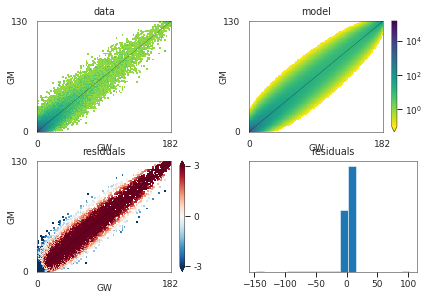

In [121]:
Plotting_Functions.Plot_2D(fs_fw, model_fit, prefix, "no_mig", vmin_val=0.1)

In [146]:
def Plot_2d(fs, model_fit, model_name, outfile, vmin_val=None):
    #Routine for plotting with 2D jsfs
    fig = pylab.figure(num = 1, figsize = (15,10))
    fig.clear()
    if vmin_val is None:
        dadi.Plotting.plot_2d_comp_multinom(model_fit, fs, resid_range = 3)
    else:
        dadi.Plotting.plot_2d_comp_multinom(model_fit, fs, resid_range = 3, vmin = vmin_val)
    print('\nPlotting {0}_{1}.pdf'.format(outfile, model_name))
    print("\nNOTE - CLOSE PLOT TO ADVANCE.")
    outname = '{0}_{1}.pdf'.format(outfile, model_name)
    fig.savefig(outname)

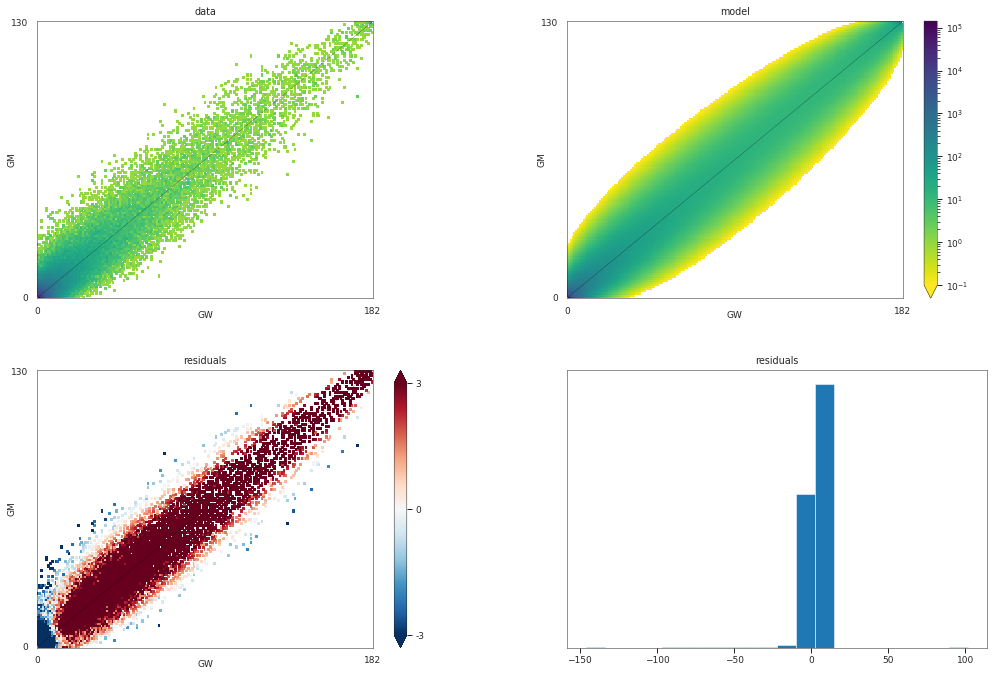


Plotting no_mig_GM_GW.png

NOTE - CLOSE PLOT TO ADVANCE.


In [147]:
Plot_2d(fs_fw, model_fit, prefix, "no_mig", vmin_val=0.1)